In [40]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import cProfile
import pstats

%load_ext line_profiler

In [2]:
def return_sf(dur, cens, bins):
    km = KaplanMeierFitter()
    km.fit(dur, cens)
    return km.survival_function_at_times(bins).to_numpy()

def return_sf_2(dur, cens, bins):
    inner_bins = np.unique(dur)
    dur_ = np.searchsorted(inner_bins, dur)
    hist_dur = np.bincount(dur_)
    hist_cens = np.bincount(dur_, weights=cens)
    cumul_hist = np.cumsum(hist_dur[::-1])[::-1]
    sf = np.hstack([1.0, np.cumprod((1.0 - hist_cens / (cumul_hist)))])
    
    place_bin = np.digitize(bins, inner_bins)
    return sf[np.clip(place_bin, 0, None)]

dur = np.random.uniform(0, 10000, 10000)
cens = np.random.choice(2, 10000)
bins = np.sort(np.random.uniform(0, 10000, 100))

wei = np.random.choice(20, 10000)

In [3]:
%timeit return_sf(dur, cens, bins)

12.9 ms ± 84.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
%timeit return_sf_2(dur, cens, bins)

1.3 ms ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


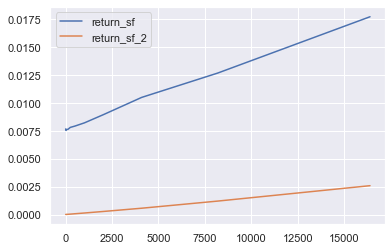

In [5]:
import timeit
def plot_km_performance_scaling_test(functions, size_samples):
    times = {func.__name__ : [] for func in functions}
    res = {func.__name__ : [] for func in functions}
    for i in size_samples:
        dur = np.random.uniform(0, 10000, i)
        cens = np.random.choice(2, i)
        bins = np.sort(np.random.uniform(0, 10000, i))
        
        for func in functions:
            sf_ = func(dur, cens, bins)
            
            res[func.__name__].append(sf_)
            times[func.__name__].append(timeit.timeit(lambda: func(dur, cens, bins), number=100)/100)
    
    fig = plt.figure()
    for func in functions:
        plt.plot(size_samples, times[func.__name__], label = func.__name__)
    plt.legend()
    plt.show()
    return times, res

times_km, res_km = plot_km_performance_scaling_test([return_sf, 
                                                     return_sf_2], 
                                                    [2**i for i in range(3, 15)])

In [6]:
for i, j in zip(res_km["return_sf"], res_km["return_sf_2"]):
    print("life", i)
    print("self", j)

life [1.         0.85714286 0.85714286 0.85714286 0.85714286 0.85714286
 0.57142857 0.        ]
self [1.         0.85714286 0.85714286 0.85714286 0.85714286 0.85714286
 0.57142857 0.        ]
life [1.         1.         1.         0.93333333 0.86666667 0.64
 0.42666667 0.42666667 0.42666667 0.42666667 0.28444444 0.14222222
 0.14222222 0.14222222 0.         0.        ]
self [1.         1.         1.         0.93333333 0.86666667 0.64
 0.42666667 0.42666667 0.42666667 0.42666667 0.28444444 0.14222222
 0.14222222 0.14222222 0.         0.        ]
life [1.         1.         1.         1.         1.         1.
 0.96153846 0.96153846 0.8361204  0.8361204  0.8361204  0.8361204
 0.8361204  0.74810773 0.70410139 0.70410139 0.70410139 0.61022121
 0.61022121 0.61022121 0.61022121 0.61022121 0.61022121 0.61022121
 0.61022121 0.43686291 0.37445392 0.37445392 0.37445392 0.37445392
 0.37445392 0.37445392]
self [1.         1.         1.         1.         1.         1.
 0.96153846 0.96153846 0.836120

In [7]:
return_sf(np.array([1, 10, 75, 100, 150]),
          np.array([1, 1, 1, 1, 1]),
          np.array([0.1, 5, 50]),
         )
# array([1. , 0.8, 0.6])
return_sf_2(np.array([1, 10, 75, 100, 150]),
          np.array([1, 1, 1, 1, 1]),
          np.array([0.1, 5, 50]),
         )
# array([0.8, 0.8, 0.6])

array([1. , 0.8, 0.6])

In [44]:
km_w = KaplanMeierFitter()
km_w.fit(dur, cens, weights = wei)
km_w.survival_function_at_times(bins).to_numpy()

array([0.99750225, 0.98729212, 0.98586686, 0.98506063, 0.98480857,
       0.97730619, 0.9766748 , 0.96651619, 0.96510875, 0.94601546,
       0.94019387, 0.93639066, 0.93200667, 0.93021555, 0.92959117,
       0.92774716, 0.91844704, 0.91746646, 0.91201298, 0.90829914,
       0.89464874, 0.89376393, 0.8895278 , 0.88706885, 0.88261588,
       0.88259412, 0.8812608 , 0.8785551 , 0.87447784, 0.8731305 ,
       0.8602645 , 0.85934969, 0.84829137, 0.83657472, 0.82084231,
       0.82057649, 0.81865023, 0.81228511, 0.80021275, 0.79519585,
       0.79519585, 0.79006413, 0.79004501, 0.78825177, 0.78667136,
       0.78612111, 0.78344725, 0.78068179, 0.77742579, 0.77533984,
       0.76171557, 0.75000514, 0.73742734, 0.72778283, 0.71759778,
       0.7105869 , 0.69707   , 0.69396151, 0.69288894, 0.66668747,
       0.66282467, 0.65335469, 0.64006394, 0.63864259, 0.6164629 ,
       0.6118418 , 0.61047254, 0.60872986, 0.59764229, 0.59545585,
       0.58245873, 0.57179486, 0.56364161, 0.55104819, 0.54625

In [16]:
km = KaplanMeierFitter()
km.fit(dur, cens)
km.survival_function_at_times(bins).to_numpy()

array([0.9977988 , 0.98681655, 0.98529484, 0.98468517, 0.98427838,
       0.97661568, 0.97589693, 0.96607909, 0.96431237, 0.94493563,
       0.93937985, 0.93562438, 0.93174019, 0.92957388, 0.92903179,
       0.92762097, 0.91822555, 0.91712493, 0.91170809, 0.90848758,
       0.89528581, 0.89427111, 0.8900863 , 0.88747394, 0.88290713,
       0.88279255, 0.8814162 , 0.87865733, 0.87461356, 0.8727594 ,
       0.85978123, 0.85883895, 0.84768506, 0.83532723, 0.82059656,
       0.82010651, 0.81863479, 0.81197238, 0.79924126, 0.79457625,
       0.79457625, 0.78898896, 0.78886152, 0.786818  , 0.78515061,
       0.7841209 , 0.78128321, 0.77882532, 0.77545096, 0.77389037,
       0.75877278, 0.74494918, 0.73276536, 0.72304469, 0.71218723,
       0.70561158, 0.69172083, 0.68863976, 0.68746291, 0.6614645 ,
       0.6573102 , 0.64878756, 0.6355849 , 0.63415678, 0.61178045,
       0.60663653, 0.6053039 , 0.60363442, 0.59283755, 0.59027152,
       0.57844965, 0.56832579, 0.56129276, 0.5482885 , 0.54232

In [18]:
wei = np.random.choice(200, 10000)

In [21]:
def return_sf_2(dur, cens, bins, weights):
    inner_bins = np.unique(dur)
    dur_ = np.searchsorted(inner_bins, dur)
    hist_dur = np.bincount(dur_, weights=weights)
    hist_cens = np.bincount(dur_, weights=cens*weights)
    cumul_hist = np.cumsum(hist_dur[::-1])[::-1]
    sf = np.hstack([1.0, np.cumprod((1.0 - hist_cens / (cumul_hist)))])
    
    place_bin = np.digitize(bins, inner_bins)
    return sf[np.clip(place_bin, 0, None)]

In [36]:
return_sf_2(dur, cens, bins, wei*1000)

array([0.99750225, 0.98729212, 0.98586686, 0.98506063, 0.98480857,
       0.97730619, 0.9766748 , 0.96651619, 0.96510875, 0.94601546,
       0.94019387, 0.93639066, 0.93200667, 0.93021555, 0.92959117,
       0.92774716, 0.91844704, 0.91746646, 0.91201298, 0.90829914,
       0.89464874, 0.89376393, 0.8895278 , 0.88706885, 0.88261588,
       0.88259412, 0.8812608 , 0.8785551 , 0.87447784, 0.8731305 ,
       0.8602645 , 0.85934969, 0.84829137, 0.83657472, 0.82084231,
       0.82057649, 0.81865023, 0.81228511, 0.80021275, 0.79519585,
       0.79519585, 0.79006413, 0.79004501, 0.78825177, 0.78667136,
       0.78612111, 0.78344725, 0.78068179, 0.77742579, 0.77533984,
       0.76171557, 0.75000514, 0.73742734, 0.72778283, 0.71759778,
       0.7105869 , 0.69707   , 0.69396151, 0.69288894, 0.66668747,
       0.66282467, 0.65335469, 0.64006394, 0.63864259, 0.6164629 ,
       0.6118418 , 0.61047254, 0.60872986, 0.59764229, 0.59545585,
       0.58245873, 0.57179486, 0.56364161, 0.55104819, 0.54625

### NA

In [5]:
km = NelsonAalenFitter()
km.fit(dur, cens)
km.cumulative_hazard_at_times(bins).to_numpy()

array([0.00573443, 0.00603809, 0.00613934, 0.00766175, 0.01195176,
       0.01669256, 0.03055265, 0.03440129, 0.04294214, 0.04655133,
       0.04732176, 0.05219301, 0.05587483, 0.06354831, 0.06594044,
       0.07739901, 0.08460335, 0.09058783, 0.09457246, 0.09566434,
       0.10054539, 0.10435815, 0.10845063, 0.11889742, 0.11966168,
       0.12017195, 0.12893766, 0.13313055, 0.13616913, 0.14541504,
       0.15663069, 0.16725981, 0.1871593 , 0.18877525, 0.1975304 ,
       0.19903003, 0.20735367, 0.21041211, 0.21379755, 0.21969929,
       0.23043427, 0.23572704, 0.24696402, 0.2472934 , 0.2524298 ,
       0.25694649, 0.25778711, 0.26065475, 0.26167075, 0.26558459,
       0.26935586, 0.2836759 , 0.28958663, 0.29593684, 0.30254128,
       0.32174033, 0.34427143, 0.3710019 , 0.3782473 , 0.38299546,
       0.42713057, 0.43021846, 0.4381329 , 0.48209644, 0.49195592,
       0.49709176, 0.53503833, 0.54508096, 0.55746517, 0.57111145,
       0.5730068 , 0.59405535, 0.64342788, 0.67077914, 0.67736

In [74]:
def return_hf_2(dur, cens, bins):
    inner_bins = np.unique(dur)
    dur_ = np.searchsorted(inner_bins, dur)
    hist_dur = np.bincount(dur_)
    hist_cens = np.bincount(dur_, weights=cens)
    cumul_hist = np.cumsum(hist_dur[::-1])[::-1]
    hf = np.hstack([0.0, np.cumsum(hist_cens / cumul_hist)])
    place_bin = np.digitize(bins, inner_bins)
    return hf[np.clip(place_bin, 0, None)]

def return_smooth_hf_2(dur, cens, bins):
    inner_bins = np.unique(dur)
    dur_ = np.searchsorted(inner_bins, dur)
    hist_dur = np.bincount(dur_).astype("int")
    deaths = np.bincount(dur_, weights=cens).astype("int")
    population = np.cumsum(hist_dur[::-1])[::-1].astype("int")
    
    cum_ = np.cumsum(1.0 / np.arange(1, np.max(population) + 1))
    hf = np.hstack([0.0, np.cumsum(cum_[population - 1] - 
                                   np.where(population - deaths - 1 >= 0,
                                            cum_[population - deaths - 1], 0))])
    place_bin = np.digitize(bins, inner_bins)
    return hf[place_bin]

# return_hf_2(dur, cens, bins)

In [82]:
isinstance(np.array([1, 1.0, 1]).dtype, int)

False

In [77]:
return_smooth_hf_2(waltons['T'], waltons['E'], waltons['T'])

array([0.00613497, 0.05040753, 0.05040753, 0.05040753, 0.09001652,
       0.09001652, 0.09001652, 0.15253663, 0.15253663, 0.15253663,
       0.15253663, 0.15253663, 0.2192277 , 0.2192277 , 0.4039346 ,
       1.4134445 , 1.4134445 , 0.03117623, 0.03117623, 0.03117623,
       0.06343698, 0.06343698, 0.11732187, 0.11732187, 0.11732187,
       0.11732187, 0.18903687, 0.18903687, 0.18903687, 0.18903687,
       0.18903687, 0.23467194, 0.23467194, 0.31568744, 0.2192277 ,
       0.60978482, 0.60978482, 1.36010168, 1.36010168, 1.36010168,
       1.36010168, 1.36010168, 1.36010168, 1.36010168, 1.36010168,
       1.36010168, 1.36010168, 1.36010168, 4.02133703, 4.02133703,
       4.02133703, 4.02133703, 4.02133703, 4.02133703, 4.02133703,
       4.02133703, 4.02133703, 4.02133703, 4.02133703, 0.19649955,
       0.58718523, 0.58718523, 1.15943938, 1.15943938, 1.15943938,
       1.15943938, 1.15943938, 2.2697747 , 2.2697747 , 2.2697747 ,
       2.2697747 , 2.2697747 , 2.2697747 , 2.2697747 , 2.26977

In [70]:
na = NelsonAalenFitter(nelson_aalen_smoothing = True)
na.fit(waltons['T'], waltons['E'])
na.cumulative_hazard_

,NA_estimate
timeline,
0.0,0.000000
6.0,0.006135
7.0,0.012308
9.0,0.031176
13.0,0.050408
15.0,0.063437
17.0,0.070016
19.0,0.090017
22.0,0.117322


In [71]:
na.cumulative_hazard_at_times(waltons['T']).to_numpy()

array([0.00613497, 0.05040753, 0.05040753, 0.05040753, 0.09001652,
       0.09001652, 0.09001652, 0.15253663, 0.15253663, 0.15253663,
       0.15253663, 0.15253663, 0.2192277 , 0.2192277 , 0.4039346 ,
       1.4134445 , 1.4134445 , 0.03117623, 0.03117623, 0.03117623,
       0.06343698, 0.06343698, 0.11732187, 0.11732187, 0.11732187,
       0.11732187, 0.18903687, 0.18903687, 0.18903687, 0.18903687,
       0.18903687, 0.23467194, 0.23467194, 0.31568744, 0.2192277 ,
       0.60978482, 0.60978482, 1.36010168, 1.36010168, 1.36010168,
       1.36010168, 1.36010168, 1.36010168, 1.36010168, 1.36010168,
       1.36010168, 1.36010168, 1.36010168, 4.02133703, 4.02133703,
       4.02133703, 4.02133703, 4.02133703, 4.02133703, 4.02133703,
       4.02133703, 4.02133703, 4.02133703, 4.02133703, 0.19649955,
       0.58718523, 0.58718523, 1.15943938, 1.15943938, 1.15943938,
       1.15943938, 1.15943938, 2.2697747 , 2.2697747 , 2.2697747 ,
       2.2697747 , 2.2697747 , 2.2697747 , 2.2697747 , 2.26977

### PLOT TEST

In [43]:
import scipy.stats as ss

class KaplanMeier:
    def __init__(self, alpha=0.05, weights=None):
        self.alpha = alpha
        self.weights = weights

    def fit(self, durations, right_censor):
        self.timeline = np.unique(durations)

        dur_ = np.searchsorted(self.timeline, durations)
        hist_dur = np.bincount(dur_)
        hist_cens = np.bincount(dur_, weights=right_censor)
        cumul_hist = np.cumsum(hist_dur[::-1])[::-1]
        self.survival_function = np.hstack([1.0, np.cumprod((1.0 - hist_cens / (cumul_hist)))])
        
        z = ss.norm.ppf(1 - self.alpha / 2)
        
        cumulative_sq_ = np.append(np.cumsum(hist_cens / (cumul_hist * (cumul_hist - hist_cens))), 0)
              
        v = np.log(self.survival_function)

        print(np.exp(-np.exp(self.survival_function - z * np.sqrt(cumulative_sq_) / v)))
        print(np.exp(-np.exp(self.survival_function + z * np.sqrt(cumulative_sq_) / v)))

    def survival_function_at_times(self, times):
        place_bin = np.digitize(times, self.timeline)
        return self.survival_function[np.clip(place_bin, 0, None)]
    
    def plot_survival_function(self):
        t = np.insert(self.timeline, 0, 0)
        print(t)
        plt.step(t, self.survival_function, label = "survival_fuction", where="post")
        plt.xlabel("timeline")
        plt.legend()
        plt.fill_between(t, self.survival_function+self.confidence_interval, 
        self.survival_function-self.confidence_interval, step="post", alpha = 0.25)       

In [9]:
from lifelines.datasets import load_waltons
waltons = load_waltons()

<AxesSubplot:xlabel='timeline'>

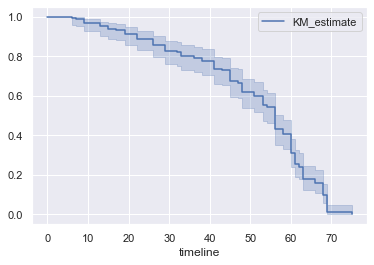

In [86]:
km_w = KaplanMeierFitter(alpha = 0.05)
km_w.fit(waltons['T'], waltons['E'])
km_w.plot_survival_function()

[ 0.  6.  7.  9. 13. 15. 17. 19. 22. 26. 29. 32. 33. 36. 38. 41. 43. 45.
 47. 48. 51. 53. 54. 56. 58. 60. 61. 62. 63. 66. 68. 69. 75.]


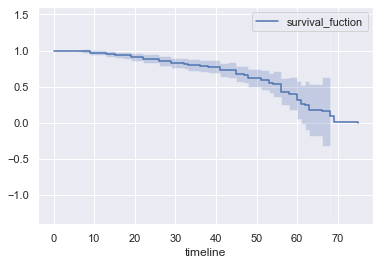

In [138]:
km_w_ = KaplanMeier()
km_w_.fit(waltons['T'], waltons['E'])
km_w_.plot_survival_function()

In [68]:
ss.norm.ppf(1 - 0.05 / 2)

1.959963984540054

In [141]:
print(km_w.confidence_interval_survival_function_)
km_w.survival_function_

      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.0                 1.000000                1.000000
6.0                 0.957254                0.999134
7.0                 0.951834                0.996917
9.0                 0.927613                0.987068
13.0                0.903821                0.975031
15.0                0.888437                0.966342
17.0                0.880865                0.961853
19.0                0.858549                0.947930
22.0                0.829547                0.928543
26.0                0.794213                0.903336
29.0                0.759669                0.877313
32.0                0.752841                0.872027
33.0                0.732496                0.856023
36.0                0.719044                0.845243
38.0                0.705674                0.834379
41.0                0.659464                0.795770
43.0                0.652931                0.790186
45.0                0.594825                0.

,KM_estimate
timeline,
0.0,1.000000
6.0,0.993865
7.0,0.987730
9.0,0.969210
13.0,0.950690
15.0,0.938344
17.0,0.932170
19.0,0.913650
22.0,0.888957


In [139]:
km_w_.survival_function + km_w_.confidence_interval

array([1.01206137, 1.01097528, 1.01514417, 1.00425553, 0.9901414 ,
       0.97986184, 0.97949303, 0.96806024, 0.95156726, 0.92845558,
       0.89910433, 0.89742683, 0.88187196, 0.87247264, 0.87038368,
       0.82863689, 0.83581192, 0.78178925, 0.78815111, 0.74319927,
       0.73639972, 0.69632897, 0.71990121, 0.61713696, 0.63473388,
       0.57690235, 0.5300622 , 0.575003  , 0.54040643, 0.63541059,
       1.4685106 ,        inf, 0.        ])

In [140]:
km_w_.survival_function - km_w_.confidence_interval

array([ 0.98793863,  0.97675478,  0.96031595,  0.93416471,  0.91123897,
        0.89682528,  0.88484746,  0.85924038,  0.82634685,  0.7877254 ,
        0.75534353,  0.7446744 ,  0.72318939,  0.70789546,  0.68529117,
        0.64061158,  0.62108992,  0.56399296,  0.54517016,  0.49043442,
        0.45985113,  0.41269526,  0.36420112,  0.24266834,  0.17522763,
        0.04614497, -0.02145214, -0.09316189, -0.1790256 , -0.31418318,
       -1.26774347,        -inf,  0.        ])

In [115]:
km_w_.survival_function

array([1.        , 0.99386503, 0.98773006, 0.96921012, 0.95069018,
       0.93834356, 0.93217025, 0.91365031, 0.88895706, 0.85809049,
       0.82722393, 0.82105061, 0.80253067, 0.79018405, 0.77783742,
       0.73462423, 0.72845092, 0.6728911 , 0.66666063, 0.61681685,
       0.59812543, 0.55451211, 0.54205117, 0.42990265, 0.40498076,
       0.31152366, 0.25430503, 0.24092055, 0.18069041, 0.1606137 ,
       0.10038356, 0.01434051, 0.        ])

In [116]:
km_w._additive_var

<bound method KaplanMeierFitter._additive_var of <lifelines.KaplanMeierFitter:"KM_estimate", fitted with 163 total observations, 7 right-censored observations>>

In [102]:
a = np.array([np.nan, 1, 2, 3])
np.nan_to_num(a, copy=False, nan=10)

a

array([10.,  1.,  2.,  3.])

In [106]:
import scipy.stats as ss

class KaplanMeier:
    def __init__(self):
        self.timeline = None
        self.survival_function = None
        self.confidence_interval_ = None
        self.alpha = 0.05

    def fit(self, durations, right_censor, weights=None):
        if weights is None:
            weights = np.ones(right_censor.shape)
        self.timeline = np.unique(durations)

        dur_ = np.searchsorted(self.timeline, durations)
        hist_dur = np.bincount(dur_, weights=weights)
        self.hist_cens = np.bincount(dur_, weights=right_censor*weights)
        self.cumul_hist_dur = np.cumsum(hist_dur[::-1])[::-1]
        self.survival_function = np.hstack([1.0, np.cumprod((1.0 - self.hist_cens / (self.cumul_hist_dur)))])

    def count_confidence_interval(self):
        z = ss.norm.ppf(1 - self.alpha / 2)
        cumulative_sq_ = np.sqrt(np.hstack([0.0, np.cumsum(self.hist_cens / (self.cumul_hist_dur * (self.cumul_hist_dur - self.hist_cens)))]))
        np.nan_to_num(cumulative_sq_, copy=False, nan=0)
        v = np.log(self.survival_function)
        np.nan_to_num(v, copy=False, nan=0)
        self.confidence_interval_ = np.vstack([np.exp(v * np.exp(- z * cumulative_sq_ / v)),
                                               np.exp(v * np.exp(+ z * cumulative_sq_ / v))]).T
        np.nan_to_num(self.confidence_interval_, copy=False, nan=1)

    def get_confidence_interval_(self):
        if self.confidence_interval_ is None:
            self.count_confidence_interval()
        return self.confidence_interval_

    def survival_function_at_times(self, times):
        place_bin = np.digitize(times, self.timeline)
        return self.survival_function[np.clip(place_bin, 0, None)]

In [107]:
km_self = KaplanMeier()
km_self.fit(y["time"], y["cens"])
km_self.get_confidence_interval_()

array([[1.        , 1.        ],
       [0.98100549, 0.99880121],
       [0.97791436, 0.99767961],
       [0.97470579, 0.99639766],
       [0.97150213, 0.99500373],
       [0.96833017, 0.99352565],
       [0.96519498, 0.99198121],
       [0.96209564, 0.99038263],
       [0.9590295 , 0.98873872],
       [0.95599364, 0.9870561 ],
       [0.95298526, 0.9853399 ],
       [0.95000185, 0.98359417],
       [0.94704118, 0.98182219],
       [0.94410132, 0.98002668],
       [0.94118056, 0.97820988],
       [0.9382774 , 0.9763737 ],
       [0.93539054, 0.97451978],
       [0.93251881, 0.97264951],
       [0.92966118, 0.97076413],
       [0.92681673, 0.96886471],
       [0.92398465, 0.96695218],
       [0.9211642 , 0.9650274 ],
       [0.91555557, 0.96114398],
       [0.91276624, 0.95918663],
       [0.90998622, 0.9572196 ],
       [0.90721506, 0.95524338],
       [0.90445233, 0.95325844],
       [0.90169764, 0.95126519],
       [0.89895066, 0.94926401],
       [0.89621104, 0.94725526],
       [0.

In [108]:
ci

array([[1.        , 1.        ],
       [0.98100549, 0.99880121],
       [0.97791436, 0.99767961],
       [0.97470579, 0.99639766],
       [0.97150213, 0.99500373],
       [0.96833017, 0.99352565],
       [0.96519498, 0.99198121],
       [0.96209564, 0.99038263],
       [0.9590295 , 0.98873872],
       [0.95599364, 0.9870561 ],
       [0.95298526, 0.9853399 ],
       [0.95000185, 0.98359417],
       [0.94704118, 0.98182219],
       [0.94410132, 0.98002668],
       [0.94118056, 0.97820988],
       [0.9382774 , 0.9763737 ],
       [0.93539054, 0.97451978],
       [0.93251881, 0.97264951],
       [0.92966118, 0.97076413],
       [0.92681673, 0.96886471],
       [0.92398465, 0.96695218],
       [0.9211642 , 0.9650274 ],
       [0.91555557, 0.96114398],
       [0.91276624, 0.95918663],
       [0.90998622, 0.9572196 ],
       [0.90721506, 0.95524338],
       [0.90445233, 0.95325844],
       [0.90169764, 0.95126519],
       [0.89895066, 0.94926401],
       [0.89621104, 0.94725526],
       [0.

In [65]:
from lifelines import KaplanMeierFitter
km = KaplanMeierFitter()
km.fit(y["time"], y["cens"])
ci = km.confidence_interval_.to_numpy()
ci

array([[1.        , 1.        ],
       [0.98100549, 0.99880121],
       [0.97791436, 0.99767961],
       [0.97470579, 0.99639766],
       [0.97150213, 0.99500373],
       [0.96833017, 0.99352565],
       [0.96519498, 0.99198121],
       [0.96209564, 0.99038263],
       [0.9590295 , 0.98873872],
       [0.95599364, 0.9870561 ],
       [0.95298526, 0.9853399 ],
       [0.95000185, 0.98359417],
       [0.94704118, 0.98182219],
       [0.94410132, 0.98002668],
       [0.94118056, 0.97820988],
       [0.9382774 , 0.9763737 ],
       [0.93539054, 0.97451978],
       [0.93251881, 0.97264951],
       [0.92966118, 0.97076413],
       [0.92681673, 0.96886471],
       [0.92398465, 0.96695218],
       [0.9211642 , 0.9650274 ],
       [0.91555557, 0.96114398],
       [0.91276624, 0.95918663],
       [0.90998622, 0.9572196 ],
       [0.90721506, 0.95524338],
       [0.90445233, 0.95325844],
       [0.90169764, 0.95126519],
       [0.89895066, 0.94926401],
       [0.89621104, 0.94725526],
       [0.

In [8]:
def to_str_from_dict_list(d, l):
    return ";".join([str(d.get(e,"")) for e in l])

f({"123": 123, "456": 456, "789": "all"}, ["123", "3", "789"])

'123;;all'

### FAST BOOSTING

In [293]:
import survivors.datasets as ds
from survivors.ensemble import BoostingCRAID
from sklearn.metrics import roc_auc_score
import cProfile
import pstats

param = {'aggreg_func': 'wei', 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'],
        'criterion': 'peto', 'depth': 15, 'ens_metric_name': 'ibs', 'max_features': 'sqrt',
        'min_samples_leaf': 1, 'mode_wei': 'square', 'n_estimators': 30, 'size_sample': 0.5, 
        "leaf_model": "base_fast"}

X, y, features, categ, sch_nan = ds.load_wuhan_dataset()

profiler = cProfile.Profile()
profiler.enable()

bst = BoostingCRAID(**param)
bst.fit(X, y)

profiler.disable()
bst_stats = pstats.Stats(profiler).sort_stats('cumtime')
bst_stats.print_stats()
# bst_stats.dump_stats(f'boost_before_optimize.pstats')

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of emp

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of emp

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of emp

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of emp

[0.2658 0.22   0.1911 0.1652 0.1566 0.1507 0.1485 0.1492 0.1494 0.1484
 0.1468 0.1439 0.1411 0.1431 0.1422 0.1415 0.1418 0.1393 0.1384 0.1388
 0.1375 0.1371 0.1378 0.1381 0.1365 0.1354 0.1345 0.1344 0.1332 0.1334]
fitted: 29 models.
         26089007 function calls (25839807 primitive calls) in 38.854 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000   38.870   12.957 C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\IPython\core\interactiveshell.py:3362(run_code)
        3    0.000    0.000   38.870   12.957 {built-in method builtins.exec}
        1    0.001    0.001   38.851   38.851 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_7160\2927153365.py:1(<cell line: 18>)
        1    0.003    0.003   38.851   38.851 C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\ensemble\boosting.py:68(fit)
       30    0.024    0.001   33.948    1.132 C:\ProgramD

In [295]:
from lifelines.utils import concordance_index
from sklearn.metrics import roc_auc_score

class FastestBoosting(BoostingCRAID):
    def add_model(self, model, x_oob, wei_i, betta_i):
        self.bettas.append(betta_i)
        self.l_weights.append(wei_i)
        self.models.append(model)
        
        if len(self.bettas) == 1:
            if self.ens_metric_name in ["ibs", "iauc"]:
                dim = (self.X_train.shape[0], self.bins.shape[0])
            else:
                dim = (self.X_train.shape[0])
            self.oob_prediction = np.zeros(dim, dtype=np.float)
            self.oob_count = np.zeros((self.X_train.shape[0]), dtype=np.int)
            
        oob_index = x_oob.index.values
        self.oob_count[oob_index] += 1
        if self.ens_metric_name == "conc":
            self.oob_prediction[oob_index] += model.predict(x_oob, target=cnt.TIME_NAME)
        elif self.ens_metric_name == "roc":
            self.oob_prediction[oob_index] += model.predict(x_oob, target=cnt.CENS_NAME)
        else:
            self.oob_prediction[oob_index] += model.predict_at_times(x_oob, bins=self.bins, mode="surv")
    
    def select_model(self, start, end):
        self.bettas = self.bettas[start:end]
        self.l_weights = self.l_weights[start:end]
        self.models = self.models[start:end]

    def aggregate_score_selfoob(self, bins=None):
        index_join_oob = np.where(self.oob_count != 0)
        if self.ens_metric_name == "ibs":
            pred = self.oob_prediction[index_join_oob] / self.oob_count[index_join_oob][:, None]
        else:
            pred = self.oob_prediction[index_join_oob] / self.oob_count[index_join_oob]

        join_oob = self.y_train[index_join_oob]
        target_time = join_oob[cnt.TIME_NAME]
        target_cens = join_oob[cnt.CENS_NAME]
        
        if self.ens_metric_name == "conc":
            return concordance_index(target_time, pred)
        elif self.ens_metric_name == "roc":
            return roc_auc_score(target_cens, pred)
        elif self.ens_metric_name == "ibs":
            y_true = cnt.get_y(target_cens, target_time)
            return metr.ibs(self.y_train, y_true, pred, self.bins)
        return None

In [296]:
profiler = cProfile.Profile()
profiler.enable()

bst = FastestBoosting(**param)
bst.fit(X, y)

profiler.disable()
bst_stats = pstats.Stats(profiler).sort_stats('cumtime')
bst_stats.print_stats()
# bst_stats.dump_stats(f'boost_after_optimize.pstats')

C:\Users\vasiliev\AppData\Local\Temp\ipykernel_7160\1008395653.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.oob_prediction = np.zeros(dim, dtype=np.float)
C:\Users\vasiliev\AppData\Local\Temp\ipykernel_7160\1008395653.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https

[0.2658 0.22   0.1911 0.1652 0.1566 0.1507 0.1485 0.1492 0.1494 0.1484
 0.1468 0.1439 0.1411 0.1431 0.1422 0.1415 0.1418 0.1393 0.1384 0.1388
 0.1375 0.1371 0.1378 0.1381 0.1365 0.1354 0.1345 0.1344 0.1332 0.1334]
fitted: 29 models.
         22560476 function calls (22324518 primitive calls) in 31.386 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000   31.403   10.468 C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\IPython\core\interactiveshell.py:3362(run_code)
        3    0.000    0.000   31.402   10.467 {built-in method builtins.exec}
        1    0.001    0.001   31.365   31.365 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_7160\1343475622.py:1(<cell line: 5>)
        1    0.004    0.004   31.364   31.364 C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\ensemble\boosting.py:68(fit)
       30    0.024    0.001   28.713    0.957 C:\ProgramDa

In [392]:
from survivors.tree.stratified_model import LeafModel, WeightSurviveModel, KaplanMeier, NelsonAalen

class FastWeightModel(LeafModel):
    def __init__(self, weights_name="weights_obs"):
        self.shape = None
        self.survival = None
        self.hazard = None
        self.features_predict = dict()
        self.lists = dict()
        self.weights_name = weights_name
        self.default_bins = np.array([1, 10, 100, 1000])

    def fit(self, X_node, need_features=[cnt.TIME_NAME, cnt.CENS_NAME]):
        if not(self.weights_name is None):
            need_features.append(self.weights_name)
        
        X_np = X_node[need_features].to_numpy(np.float32).T
        self.shape = X_np.shape
        self.features_predict = dict(zip(need_features, X_np.mean(axis=1)))
        self.lists = dict(zip(need_features, X_np))
        
        if self.weights_name is None:
            self.weights = np.ones(self.shape[1])
        else:
            self.weights = self.lists[self.weights_name]

    def predict_survival_at_times(self, X=None, bins=None):
        if bins is None:
            bins = self.default_bins
        if self.survival is None:                
            self.survival = KaplanMeier()
            self.survival.fit(self.lists[cnt.TIME_NAME],
                              self.lists[cnt.CENS_NAME],
                              self.weights)
        sf = self.survival.survival_function_at_times(bins)
        if X is None:
            return sf
        return np.repeat(sf[np.newaxis, :], X.shape[0], axis=0)

    def predict_hazard_at_times(self, X=None, bins=None):
        if bins is None:
            bins = self.default_bins
        
        if self.hazard is None:                
            self.hazard = NelsonAalen()
            self.hazard.fit(self.lists[cnt.TIME_NAME],
                            self.lists[cnt.CENS_NAME],
                            self.weights)
        hf = self.hazard.cumulative_hazard_at_times(bins)
        if X is None:
            return hf
        return np.repeat(hf[np.newaxis, :], X.shape[0], axis=0)    

In [11]:
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
X_ = X.copy()
X_[cnt.TIME_NAME] = y[cnt.TIME_NAME]
X_[cnt.CENS_NAME] = y[cnt.CENS_NAME]
bins = np.arange(max(y[cnt.TIME_NAME]))

X_ = pd.concat([X_]*2, ignore_index=True)

NameError: name 'ds' is not defined

In [396]:
def test_model(model, X, bins):
    w = model(weights_name=None)
    w.fit(X)
    a = w.predict_survival_at_times(bins=bins)
    b = w.predict_hazard_at_times(bins=bins)
    return (a, b)

%timeit test_model(WeightSurviveModel, X_, bins)

(array([1.        , 1.        , 1.        , ..., 0.34275849, 0.34275849,
        0.34275849]),
 array([0.        , 0.        , 0.        , ..., 1.06571382, 1.06571382,
        1.06571382]))

In [397]:
%timeit test_model(FastWeightModel, X_, bins)

(array([1.        , 1.        , 1.        , ..., 0.34275849, 0.34275849,
        0.34275849]),
 array([0.        , 0.        , 0.        , ..., 1.06571382, 1.06571382,
        1.06571382]))

In [348]:
w.lists

{}

In [363]:
X_np = X_.loc[:, [cnt.TIME_NAME, cnt.CENS_NAME]].to_numpy().T
dict(zip([cnt.TIME_NAME, cnt.CENS_NAME], X_np.mean(axis=1)))

{'time': 1124.4897959183672, 'cens': 0.4358600583090379}

In [364]:
X_np.shape

(2, 68600)

In [355]:
dict(zip([cnt.TIME_NAME, cnt.CENS_NAME], X_np.T))

{'time': array([1814.0, 2018.0, 712.0, ..., 769.0, 727.0, 1701.0], dtype=object),
 'cens': array([True, True, True, ..., True, True, True], dtype=object)}

In [369]:
X_np

array([[1814.0, 2018.0, 712.0, ..., 769.0, 727.0, 1701.0],
       [True, True, True, ..., True, True, True]], dtype=object)

In [356]:
X_np.mean(axis=0)

array([1124.4897959183672, 0.4358600583090379], dtype=object)

In [357]:
X_np.T.mean(axis=1)

array([1124.4897959183672, 0.4358600583090379], dtype=object)

In [377]:
X_/

array([[1814.0, True],
       [2018.0, True],
       [712.0, True],
       ...,
       [769.0, True],
       [727.0, True],
       [1701.0, True]], dtype=object)

In [381]:
X_[[cnt.TIME_NAME, cnt.CENS_NAME]].to_numpy()

array([[1814.0, True],
       [2018.0, True],
       [712.0, True],
       ...,
       [769.0, True],
       [727.0, True],
       [1701.0, True]], dtype=object)

In [415]:
from sklearn.model_selection import train_test_split
X_CV, X_HO = train_test_split(X, stratify = y[cnt.CENS_NAME], test_size=0.33, random_state=43)
y_CV = y[X_CV.index]
y_HO = y[X_HO.index]

In [419]:
type(eval("{'1': '2', '123': '34'}"))

dict

In [433]:
df = pd.DataFrame([{1: 2, 3: 4, 5: 6},
                   {1: 22, 3: 42, 5: 62}])

for ind, (i, j) in enumerate(zip(df[1], df[3])):
    print(ind, i, j)
    df.loc[ind, ["IBS"]] = i + j

0 2 4
1 22 42


In [434]:
df

,1,3,5,IBS
0,2,4,6,6.0
1,22,42,62,64.0


In [438]:
X.loc[X.index, :]

,htreat,age,menostat,tumsize,tumgrad,posnodal,prm,esm
0,0,70,2,21,2,3,48,66
1,1,56,2,12,2,7,61,77
2,1,58,2,35,2,9,52,271
3,1,59,2,17,2,4,60,29
4,0,73,2,35,2,1,26,65
...,...,...,...,...,...,...,...,...
681,0,49,1,30,3,3,1,84
682,1,53,2,25,3,17,0,0
683,0,51,1,25,3,5,43,0
684,0,52,2,23,2,3,15,34


In [443]:
X1, X2 = train_test_split(X, stratify=y[cnt.CENS_NAME], test_size=0.33, random_state=42)

In [446]:
X.loc[X1.index, :], X.loc[X2.index, :]

(     htreat  age  menostat  tumsize  tumgrad  posnodal  prm  esm
 323       0   37         1       50        3         2  170  130
 125       0   60         2       15        2         2   84   93
 410       0   52         2       25        3         3   10   15
 241       1   54         2       25        2         1    5   57
 55        0   63         2       40        2         3    5    8
 ..      ...  ...       ...      ...      ...       ...  ...  ...
 36        0   62         2       22        2        12    0    8
 612       0   51         2       25        2         2    0   80
 263       1   52         2       25        2        13    0    0
 384       1   47         1       12        2         1  110   14
 307       1   62         2       20        2         1   11    6
 
 [459 rows x 8 columns],
      htreat  age  menostat  tumsize  tumgrad  posnodal  prm  esm
 449       1   62         2       20        2         1  100  100
 545       0   50         1       13        3    

In [458]:
from sklearn.model_selection import train_test_split

def prepare_sample(X, y, train_index, test_index):
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    bins = cnt.get_bins(time=y_train[cnt.TIME_NAME], cens=y_train[cnt.CENS_NAME])
    y_train[cnt.TIME_NAME] = np.clip(y_train[cnt.TIME_NAME], bins.min() - 1, bins.max() + 1)
    y_test[cnt.TIME_NAME] = np.clip(y_test[cnt.TIME_NAME], bins.min(), bins.max())
    return X_train, y_train, X_test, y_test, bins

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
X_TR, X_HO = train_test_split(X, stratify=y[cnt.CENS_NAME], test_size=0.33, random_state=42)
print(X_TR.index, X_HO.index, X.index)
X, y, X_HO, y_HO, bins = prepare_sample(X, y, X_TR.index, X_HO.index)

Int64Index([323, 125, 410, 241,  55, 285, 342, 335, 587, 295,
            ...
            167, 163,  64, 251, 229,  36, 612, 263, 384, 307],
           dtype='int64', length=459) Int64Index([449, 545, 200, 217,   3, 597, 240, 479, 547, 653,
            ...
             15, 467, 408, 191, 665, 583,   4,  31, 136, 215],
           dtype='int64', length=227) RangeIndex(start=0, stop=686, step=1)


In [459]:
X_HO

,htreat,age,menostat,tumsize,tumgrad,posnodal,prm,esm
449,1,62,2,20,2,1,100,100
545,0,50,1,13,3,5,8,32
200,0,43,1,30,2,3,45,11
217,1,63,2,30,2,7,0,0
3,1,59,2,17,2,4,60,29
...,...,...,...,...,...,...,...,...
583,0,65,2,10,1,2,213,209
4,0,73,2,35,2,1,26,65
31,0,36,1,44,3,2,6,5
136,1,37,1,25,2,1,235,38


In [12]:
from survivors import datasets as ds
X, y, features, categ, sch_nan = ds.load_pbc_dataset()

In [472]:
var = np.array([0, 0, 0, 0]) 
li = np.ones_like(var) / var.shape[0]

pred_wei = np.array([1, 1, 1, 1])
norm_wei = pred_wei/pred_wei.sum()
(li * norm_wei).sum()

0.25

In [466]:
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold

# tscv = TimeSeriesSplit()
# for train_index, test_index in tscv.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)

skf = StratifiedKFold(n_splits=5)
train_index_pred = np.array([])
for train_index, test_index in skf.split(X, y[cnt.CENS_NAME]):
    if train_index_pred.shape[0] > 0:
        print("TRAIN:", train_index, "TEST:", test_index_)
    train_index = np.hstack([train_index, test_index_])

TRAIN: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 92.] TEST: [ 91  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 183 184]
TRAIN: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  

In [461]:
X

,htreat,age,menostat,tumsize,tumgrad,posnodal,prm,esm
323,0,37,1,50,3,2,170,130
125,0,60,2,15,2,2,84,93
410,0,52,2,25,3,3,10,15
241,1,54,2,25,2,1,5,57
55,0,63,2,40,2,3,5,8
...,...,...,...,...,...,...,...,...
36,0,62,2,22,2,12,0,8
612,0,51,2,25,2,2,0,80
263,1,52,2,25,2,13,0,0
384,1,47,1,12,2,1,110,14
